In [1]:
!pip install --quiet pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 62.8 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import numpy as np
import pandas as pd
import pywt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

2025-05-19 19:16:55.596175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747682215.865530      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747682215.937773      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset_a=pd.read_csv("/kaggle/input/darwin-asif/data.csv")
dataset_a=dataset_a.drop(['ID'],axis=1,inplace=False)
dataset_a.dropna()
dataset_a.head()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,0.051836,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,0.039827,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,0.064220,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,0.090408,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,0.037528,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [4]:
y = dataset_a['class']

In [5]:
dataset=dataset_a.drop('class',axis='columns')

In [6]:
chi_ls = []

for feature in dataset.columns:
    
    # create contingency table
    c = pd.crosstab(y, dataset[feature])
    # chi_test
    p_value = chi2_contingency(c)[1]
    chi_ls.append(p_value)

Text(0.5, 1.0, 'Feature importance based on chi-square test')

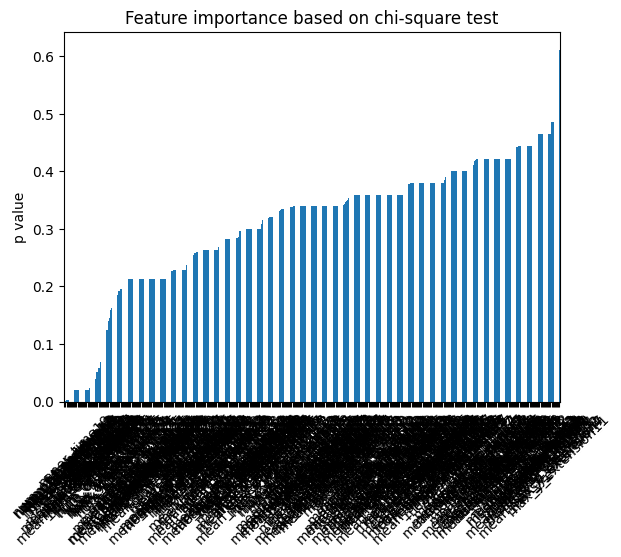

In [7]:
pd.Series(chi_ls, index=dataset.columns).sort_values(ascending=True).plot.bar(rot=45)
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')

In [8]:
# select top 4

selected = pd.Series(chi_ls, index=dataset.columns).sort_values(
    ascending=True)[0:4].index

selected

Index(['num_of_pendown23', 'num_of_pendown19', 'num_of_pendown18',
       'num_of_pendown4'],
      dtype='object')

In [9]:
dataset=dataset[selected]
dataset.head()

,num_of_pendown23,num_of_pendown19,num_of_pendown18,num_of_pendown4
0,12,43,3,11
1,14,82,6,5
2,12,42,4,1
3,11,78,6,9
4,12,53,4,9


# Quantum Variational Encoder

In [10]:
import pennylane as qml
from pennylane import numpy as np

# Define the quantum device
n_qubits = 4  # One qubit per input feature
dev = qml.device("default.qubit", wires=n_qubits)

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [11]:
# Define the variational quantum encoder
def variational_encoder(features, weights):
    # Step 1: Encode the input features into quantum states
    for i in range(n_qubits):
        qml.RY(features[i], wires=i)
    
    # Step 2: Apply trainable variational layers
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    
    # Step 3: Measure the expectation values of the first two qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]  # Reduced to 2 dimensions


In [12]:
# Create the quantum node
@qml.qnode(dev)
def quantum_encoder(features, weights):
    return variational_encoder(features, weights)

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y=label_encoder.fit_transform(y)

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Normalize the features to [-π, π]
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X= scaler.fit_transform(dataset)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Cost function with both components of reduced features
def cost(weights, X, y):
    loss = 0
    for i in range(len(X)):
        # Use the encoder to reduce the dimensionality
        reduced_features = quantum_encoder(X[i], weights)
        
        # Combine the reduced features into a linear classifier
        prediction = 1 / (1 + np.exp(-(reduced_features[0] + reduced_features[1])))  # Combine both features
        
        # Calculate binary cross-entropy loss
        loss += -y[i] * np.log(prediction) - (1 - y[i]) * np.log(1 - prediction)
    return loss / len(X)


In [16]:
# Initialize weights for the variational circuit
n_layers = 3  # Number of layers
weights = np.random.uniform(-np.pi, np.pi, size=(n_layers, n_qubits, 3))  # Shape required for StronglyEntanglingLayers

# Optimizer and training parameters
opt = qml.GradientDescentOptimizer(stepsize=0.1)
epochs = 20

# Training loop
for epoch in range(epochs):
    weights = opt.step(lambda w: cost(w, X_train, y_train), weights)
    train_loss = cost(weights, X_train, y_train)
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}")

Epoch 1: Train Loss = 0.7122
Epoch 2: Train Loss = 0.7106
Epoch 3: Train Loss = 0.7090
Epoch 4: Train Loss = 0.7074
Epoch 5: Train Loss = 0.7059
Epoch 6: Train Loss = 0.7043
Epoch 7: Train Loss = 0.7028
Epoch 8: Train Loss = 0.7013
Epoch 9: Train Loss = 0.6998
Epoch 10: Train Loss = 0.6983
Epoch 11: Train Loss = 0.6969
Epoch 12: Train Loss = 0.6954
Epoch 13: Train Loss = 0.6940
Epoch 14: Train Loss = 0.6926
Epoch 15: Train Loss = 0.6912
Epoch 16: Train Loss = 0.6898
Epoch 17: Train Loss = 0.6885
Epoch 18: Train Loss = 0.6872
Epoch 19: Train Loss = 0.6859
Epoch 20: Train Loss = 0.6846


In [17]:
# Training loop
for epoch in range(epochs):
    weights = opt.step(lambda w: cost(w, X_train, y_train), weights)
    train_loss = cost(weights, X_train, y_train)
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}")

Epoch 1: Train Loss = 0.6833
Epoch 2: Train Loss = 0.6820
Epoch 3: Train Loss = 0.6808
Epoch 4: Train Loss = 0.6796
Epoch 5: Train Loss = 0.6784
Epoch 6: Train Loss = 0.6772
Epoch 7: Train Loss = 0.6760
Epoch 8: Train Loss = 0.6749
Epoch 9: Train Loss = 0.6738
Epoch 10: Train Loss = 0.6727
Epoch 11: Train Loss = 0.6716
Epoch 12: Train Loss = 0.6705
Epoch 13: Train Loss = 0.6694
Epoch 14: Train Loss = 0.6684
Epoch 15: Train Loss = 0.6674
Epoch 16: Train Loss = 0.6664
Epoch 17: Train Loss = 0.6654
Epoch 18: Train Loss = 0.6644
Epoch 19: Train Loss = 0.6634
Epoch 20: Train Loss = 0.6625


In [18]:
weights

tensor([[[-2.42801314,  1.50571779,  1.2283029 ],
         [-2.17145884,  0.15896424,  0.16333919],
         [-0.15374949,  1.68920004, -1.65872681],
         [-1.44490547,  2.62276969,  1.27242623]],

        [[ 2.58167573,  2.13032372,  2.66971356],
         [-2.78479649,  0.98276543,  3.06833874],
         [-2.10633929,  2.53046439, -3.05193983],
         [-1.40572798,  2.89441513, -0.59473482]],

        [[-2.19864572,  1.95903031,  1.04381385],
         [ 0.54700659,  0.71298664,  1.88667846],
         [-1.69956049, -1.46239891, -1.90177885],
         [-2.58360992, -2.41447692, -0.32676376]]], requires_grad=True)

In [19]:
# Use the trained encoder to reduce the dataset to 2 features
reduced_features_train = np.array([quantum_encoder(features, weights) for features in X_train])
reduced_features_test = np.array([quantum_encoder(features, weights) for features in X_test])

In [ ]:
#reduced_features_train

# Classical SVM

In [28]:
from sklearn.svm import SVC

model = SVC(kernel='rbf')  # You can also try other kernels like 'rbf', 'poly', or 'sigmoid'
model.fit(reduced_features_train, y_train)

SVC()

In [29]:
# Make predictions on the test set
y_pred = model.predict(reduced_features_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.74


In [30]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.87      0.74        15
           1       0.87      0.65      0.74        20

    accuracy                           0.74        35
   macro avg       0.76      0.76      0.74        35
weighted avg       0.77      0.74      0.74        35



In [31]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_pred)
print(f"AUC: {auc}")

AUC: 0.7583333333333333


# Classical Ensemble Model

In [32]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

base_models = [
    ('svm', SVC(probability=True, random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42))
]

In [33]:
# Meta-model
meta_model = LogisticRegression()

# Stacking ensemble
stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking.fit(reduced_features_train, y_train)

StackingClassifier(estimators=[('svm', SVC(probability=True, random_state=42)),
                               ('tree',
                                DecisionTreeClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
y_pred_e = stacking.predict(reduced_features_test)
y_pred_proba = stacking.predict_proba(reduced_features_test)[:, 1]  # Probabilities for positive class

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_e))

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.80      0.71        15
           1       0.81      0.65      0.72        20

    accuracy                           0.71        35
   macro avg       0.72      0.73      0.71        35
weighted avg       0.73      0.71      0.72        35



In [35]:
auc_q = roc_auc_score(y_test,y_pred_e)
print(f"AUC: {auc_q}")

AUC: 0.7250000000000001
